# Introduction -- Reminder

Each Python lab will start with a pre-flight exercise that walks through building some of the set up and tools ($\sim$ 30 min), followed by an in-class tutorial with time for Q+A (50 min) so you can walk through steps that will be necessary for the homework assignment you will submit ($\sim$ 3 hrs).  Each lab will contain starter code, similar to what you see below.  Please fill in the code to complete the pre-flight assignment in preparation for the in-class tutorial.  

Preflight ($\sim$30-60 min, 10 points) **Typically due: Wednesdays 3pm EST**

*Preflight typically graded by Wednesday 5p EST*

In-class tutorial and Q+A ($\sim$ 50 min, 10 points) **Typically occurs: Thursdays 9am EST**

Homework assignment ($\sim$ 3-5 hrs, 30 points) **Typically due: Mondays 9am EST** 

*Homework typically graded by Thursday 5p*

When we grade your homework, we will not run your code. Once submitted, your notebook should have the outputs for all of your results.  Please do not include long outputs from debugging, beyond a few print statements and the requested visualizations (i.e. plots).

**Grading:** When we grade your notebook, we will convert the .ipynb file to an HTML file.  We will be using [nbgrader](https://nbgrader.readthedocs.io/en/stable/) to grade your notebooks.  **Note:** If your ```IPython``` version is too old, we will *not* be able to grade your assignments.


# Phys 260 Python Lab 3: Boundary conditions (20 points total)

## Tutorial summary
- Method of relaxation for setting the potential with boundary conditions
- Plotting a scalar field (e.g. the potential V)

In [100]:
import numpy as np
from matplotlib import pyplot as plt

## Brief review
- Taking derivatives on a grid
- Extension to 2d

## Background of application (quick review of the vector calculus between $\vec{E}$ and V)

In lectures you saw, 
\begin{equation}
\vec E = - \vec \nabla V, ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (1) }
\end{equation}
where $\vec \nabla = \left(\frac{\partial}{\partial x},\frac{\partial}{\partial y},\frac{\partial}{\partial z}\right)$ in cartesian coordinates,
 and 
 \begin{equation}
\vec E = \int \frac {\rho d\tau} {4 \pi \epsilon_0}\frac {\hat r} {r^2}.~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (2) }
\end{equation}
Here $d\tau$ is the differential volume element (e.g. $d\tau=dxdydz$) to avoid confusion with $V$ which is the potential.

Equation (2) is an integral equation.  The inverse of integration is taking a derivative.  Taking the divergence of both sides of Equation (2), we arrive at the differential form of Gauss' law:

\begin{equation}
\vec \nabla \cdot \vec E = \frac \rho {\epsilon_0}. ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (3) }
\end{equation}

If we now substitute Equation (1) into this equation we get: 
\begin{equation}
\nabla^2 V= \frac {- \rho} {\epsilon_0}.~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (4) }
\end{equation}

It might help to write out how this works out in Cartesian coordinates in case the nabla-notation is new to you:

\begin{equation}
\vec{\nabla}_{\mathrm{cart}}=\left[\frac{\delta}{\delta x},\frac{\delta}{\delta y}, \frac{\delta}{\delta z}\right]
=\left[\delta_x,\delta_y,\delta_z\right] = \delta_x\hat{i} + \delta_y\hat{j} + \delta_z\hat{k}
\end{equation}

Expressing the electric field in terms of the potential, we have,
\begin{equation}
\vec{E} = -\vec{\nabla}_{\mathrm{cart}}V=-\left[\frac{\delta V}{\delta x},\frac{\delta V}{\delta y}, \frac{\delta V}{\delta z}\right]
=-\left[\delta_xV,\delta_yV,\delta_zV\right] = -\delta_xV\hat{i} - \delta_yV\hat{j} - \delta_zV\hat{k} = E_x\hat{i}+E_y\hat{j}+E_z\hat{k}
\end{equation}

And, explicitly writing out equation (3):
\begin{equation}
\vec \nabla \cdot \vec E = \delta_xE_x+\delta_yE_y+\delta_zE_z = \frac \rho {\epsilon_0}. 
\end{equation}

And, explicitly writing out equation (4) in cartesian coordinates:
\begin{equation}
\left(\vec \nabla \cdot (-\vec{\nabla}V\right) = \left[\delta_x,\delta_y,\delta_z\right] \cdot \left[-\delta_xV,-\delta_yV,-\delta_zV\right] = -\left(\delta_x^2V + \delta_y^2V + \delta_z^2V\right) = -\nabla^2 V,
\end{equation}
so, 
\begin{equation}
\nabla^2V = -\frac{\rho}{\epsilon_0}
\end{equation}
where, $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}$.

This simplifies when we restrict ourselves to the case where we are considering the potential in regions where there are absolutely no charges (e.g., $\rho = 0$).  Then we have:
\begin{equation}
\nabla^2 V= 0.  ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (5) }
\end{equation}
Equation 5 is just saying that the second derivative of the potential $V$ is zero in regions where there are no charges.  If this were one dimensional then this would mean that the potential can have slopes and nothing more complicated that that.    

A TLDR: The ingredients for Equation 5:
- Coulomb's law, Equation (2) and (3) with the integral and differential forms
- The definition of the potential, Equation (1) 
- The choice that we will only consider regions that are charge free.  

Assuming our problem satisfies condition (c) then Equation 5 completely specifies the electric field and is equivalent to solving Coulomb's law.  Of course you need Equation (1) to recover the field.   You might think that (c) is a big restriction, but it isn't.  You just carefully cut out the regions that have charges, figure out the potential on the boundary of the regions you had to remove and then plug ahead with (5).   


The generalization of this statement to 2 and 3 dimensions will lend itself to a very easy numerical method for solving for the potential.  We'll come back to this in the next section.

## Relaxing the potential in 1-d

Now, we exploit the fact that "the potential has slopes, and nothing else" for the $\rho=0$ (i.e. $\nabla^2V=0$), and we use the method of relaxation to calculate the potential at all points, given the boundary conditions.  

For 1-d, (e.g. $\frac{d^2 V(x)}{d x^2} = 0$), the solution is $V(x) = ax + b$, or a straight line with a slope.  For a straight line, the potential at any point is the average of the value at points an equal distance to the right and left of that point, e.g. $V(x_i) = \left(V(x_{i+1}) + V(x_{i-1})\right)/2$.  

The extension to two dimensions is that the potential at any point is the average of the potential in a circle around that point (all points equidistant in 2d).  The extension to three dimensions is that potential at any point is the average of the potential in a sphere (again, all points equidistant in 3d).  We are exploiting [Taylor's theorem](https://en.wikipedia.org/wiki/Taylor%27s_theorem).  

**Group exercise** (5 min -- 2 points): Let us first set up boundary conditions of the potential in 1-d.  
- First, set up some one-dimensional position coordinates, `x_positions_1d = np.arange(0,20,0.2)`
- Start with a 1-d array, `potential_1d` of zeros with the same shape as `x_positions_1d`.
- Set the boundary conditions for the first (left edge) and last elements (right edge) of `potential_1d` to be -100 and 100 respectively

In [132]:
# Define x_positions_1d, and potential_1d here
### BEGIN SOLUTION
x_positions_1d = np.arange(0,20,0.2)
potential_1d = np.zeros(x_positions_1d.shape)
potential_1d[0] = -100
potential_1d[-1] = 100
### END SOLUTION

In [133]:
"""Execute to check you're on the right track"""
assert(potential_1d.shape == x_positions_1d.shape)
### BEGIN HIDDEN TESTS
assert((x_positions_1d == np.arange(0,20,0.2)).all())
assert((potential_1d[1:-1] == 0).all())
assert(potential_1d[0] == -100)
assert(potential_1d[-1] == 100)
### END HIDDEN TESTS

Now, we numerically enforce that $\frac{d^2 V(x)}{d x^2} = 0$, by iteratively setting $V(x_i) = \left(V(x_{i+1}) + V(x_{i-1})\right)/2$ and setting the boundary conditions.  Note, this is now the `potential_right` and `potential_left` that we can define using `np.roll` from the preflight.  In the next exercise, we do *one* such iteration.

**Group exercise** (5 min -- 2 points): Define a function `relax_potential_1d` that takes in the potential array as an argument, uses `np.roll` to define `potential_right` ($V(x_{i+1})$) and `potential_left` ($V(x_{i-1})$), and returns the average with the boundary conditions set.  Below, you'll need to: 
- fill in the missing pieces of the function by defining `potential_right` and 
- enforce the boundary conditions determined by the key word arguments as you did in the previous exercise.

In [134]:
def relax_potential_1d(potential_array, left_edge_condition = -100, right_edge_condition = 100) :
    """Returns relaxed 1-d potential array with set boundary conditions.  

    Inputs:
    potential_array (n-darray) : array containing the potential at each sampled point 
    left_edge_condition (float) : value of potential on left edge
    right_edge_condition (float) : value of potential on right edge

    Outputs:
    relaxed_potential (n-darray) : array containing the relaxed potential at each sampled point with boundary conditions set     
    """
    
    # Define potential_left and potential_right using np.roll (i.e. V(x_{i-1}) and V(x_{i+1})
    potential_left = np.roll(potential_array,-1) # This is V(x_{i-1})
    ### BEGIN SOLUTION
    potential_right = np.roll(potential_array,1)
    ### END SOLUTION
    
    relaxed_potential = np.mean(np.array([potential_left, potential_right]),axis=0)
    
    # Set boundary conditions
    ### BEGIN SOLUTION
    relaxed_potential[0] = left_edge_condition
    relaxed_potential[-1] = right_edge_condition
    ### END SOLUTION
    
    return relaxed_potential

In [135]:
"""Execute to check you're on the right track"""
assert(relax_potential_1d(potential_1d).shape == potential_1d.shape)
### BEGIN HIDDEN TESTS
assert(relax_potential_1d(potential_1d)[0] ==-100)
### END HIDDEN TESTS

### Iterate over the relaxation step

Let's now iterate over relaxing the potential for 500 steps, and see how it changes every 100 steps.

In [136]:
# Initialize the potential
potential_1d = np.zeros(x_positions_1d.shape)

# Take snapshots of the relaxing potential
potential_snapshots = []

# Relax over 500 iterations
for step in np.arange(500) :
    potential_1d = relax_potential_1d(potential_1d)
    if step % 100 == 0 :
        potential_snapshots.append(potential_1d)

### Plot snapshots of the relaxation

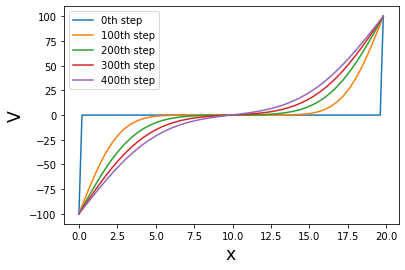

In [137]:
for i, potential_snapshot in enumerate(potential_snapshots) :
    plt.plot(x_positions_1d, potential_snapshot, label='%ith step'%(i*100))
    
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('V', fontsize='xx-large')
plt.legend()

**Discussion question** (2 min -- 2 points) : What is happening to the potential as we do more and more iterations (steps)?  What do you expect to happen as we go towards infinite iterations (e.g. steps $\rightarrow\inf$)?

**Answer**:
The potential converges, as the difference between the potential in a previous step and this one decreases.

**Group Exercise:** (10 min -- 5 points)  You will now refactor the code where we relaxed the potential over 500 steps.  *Code refactoring* refers to improving existing code.

Old code:
```
# Initialize the potential
potential_1d = np.zeros(x_positions_1d.shape)

# Take snapshots of the relaxing potential
potential_snapshots = []

# Relax over 500 iterations
for step in np.arange(500) :
    potential_1d = relax_potential_1d(potential_1d)
    if step % 100 == 0 :
        potential_snapshots.append(potential_1d)
```
In the next cell, you will refactor this code to continue iterations until "convergence" to avoid hard coding the number of iterations.  In this case, your code will not assume a number of iterations (e.g. 500), but stops once the largest difference between the potential at a given point in the previous iteration and the potential at that given point in the current iteration is less than 0.01.  We will use 0.01 as a criterion for *convergence*, and you will use a `while` loop.  

A simple example of the `while` loop is:
```
i = 20
while i > 10 : 
    i -= 1
    print(i)
```
The above code will print 20, 19, ... 11 and then exit the loop once the boolean fails.

The skeleton to the code you will need to write is below where we have already defined `convergence_criterion`, initialized the `largest_iteration_difference` (serving the same purpose as the variable i in the example).  The step of initializing the potential, and creating an empty `list`, `largest_iteration_differences` to collect the largest iteration is also already below.  You will need to fill out the `while` loop. Some suggestions:
- You will need to compare both the relaxed potential (i.e. the returned array from the function `relax_potential_1d`) and the potential just before the relaxation.  The first line inside the `while` loop will help you do this.
- You will care about the largest difference between the two, e.g. `np.max(np.abs(relaxed_potential - potential_1d))`.  

In [138]:
# Refactored code here

convergence_criterion = 0.01
largest_iteration_difference = 1 # initialize

# Initialize the potential
potential_1d = np.zeros(x_positions_1d.shape)

# Collect the largest_iteration_difference
largest_iteration_differences = []

while largest_iteration_difference > convergence_criterion :
    relaxed_potential = relax_potential_1d(potential_1d)
    ### BEGIN SOLUTION
    largest_iteration_difference = np.max(np.abs(relaxed_potential - potential_1d))
    largest_iteration_differences.append(largest_iteration_difference)
    potential_1d = relaxed_potential
### END SOLUTION

In [139]:
"""Execute to check you are on the right track"""
assert(largest_iteration_difference <= convergence_criterion)
### BEGIN HIDDEN TESTS
assert((relaxed_potential == potential_1d).all())
### END HIDDEN TESTS

Below, we plot 
- how quickly the relaxation method converged, and also 
- the final 1d potential.

Note, we make use of the subplots method, where we can have multiple axes on a single figure.

Text(0, 0.5, 'V')

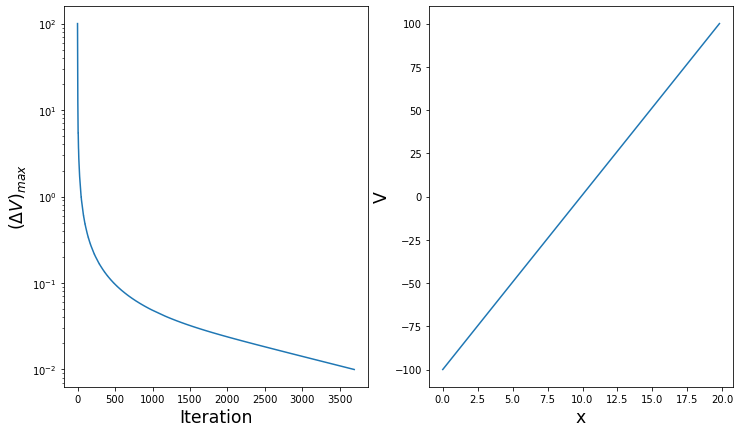

In [140]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))
ax1.plot(largest_iteration_differences)
ax1.set_yscale('log')
ax1.set_xlabel('Iteration', fontsize='xx-large')
ax1.set_ylabel('$(\Delta V)_{max}$', fontsize='xx-large')

ax2.plot(x_positions_1d, potential_1d)
ax2.set_xlabel('x', fontsize='xx-large')
ax2.set_ylabel('V', fontsize='xx-large')

## Calculate the electric field

Now, we will take the 1-d potential, and calculate the electric field.  Recall, to calculate $E$ from $V$, you must calculate the vector of partial derivatives of $V$. In 1d, to compute $E_x = -\partial V/\partial x$, you would take a first derivative using only the $x$-components of $V$.  

**Quick exercise** (2 min -- 2 points) : Define a function `calc_efield_1d(potential_array)` using `np.gradient`.

In [141]:
def calc_efield_1d(potential_array) :
    """Calculate the electric field in one dimension

    Inputs:
    potential_array (n-darray) : array containing the potential at each sampled point 

    Outputs:
    efield_array (n-darray) : array containing the corresponding efield at each sampled point     
    """
    
    ### BEGIN SOLUTION
    return np.gradient(potential_array)
    ### END SOLUTION

In [142]:
"""Execute to check you're on the right track"""
assert((calc_efield_1d(np.zeros(20))==np.zeros(20)).all())
### BEGIN HIDDEN TESTS
assert((calc_efield_1d(potential_1d) == np.gradient(potential_1d)).all())
### END HIDDEN TESTS

**Quick plot** (2 min -- 2 points): Use the `plt.subplots` method to generate two axes on a single figure on which you will plot the 1d potential and 1d electric field side by side.  You'll notice some noise in the electric field.  

Try setting `convergence_criterion = 0.001` where it was set before, and run all cells after.  How does the electric field change? 

Text(0, 0.5, 'E')

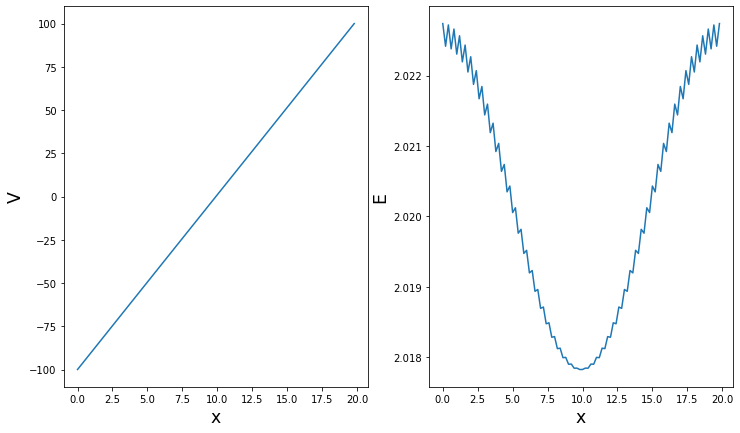

In [143]:
# Plot the potential and efield here
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))
### BEGIN SOLUTION
ax1.plot(x_positions_1d, potential_1d)
ax1.set_xlabel('x', fontsize='xx-large')
ax1.set_ylabel('V', fontsize='xx-large')

ax2.plot(x_positions_1d, calc_efield_1d(potential_1d))
ax2.set_xlabel('x', fontsize='xx-large')
ax2.set_ylabel('E', fontsize='xx-large')

### END SOLUTION

# Phys 260 Python Lab 3: Relaxing the potential in 2d with boundary conditions: The setup for modeling a capacitor (10 points total)


Your homework assignment begins here.  Note, the homework below relies on code built during the tutorial (above)


## Homework summary 
- Extending the method of relaxation in 2d
- Plotting the 2d scalar field of the potential and vector field of $\vec{E}$

The extension to 2d sets us up for modeling a capacitor, which we will do next week.  

Our 2-d potential that we will discretize and solve for will be Equation (5), explicitly written as:
\begin{equation}
\frac{\partial^2V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2}  = 0.~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (6) }
\end{equation}



In 2d, the relaxation process involves setting the potential at any given point equal to the potential in a circle around it.  On a grid, this corresponds to the points above, below, to the left, and to the right. 

You will do an analogous iterative method to solve for the potential in 2d. Recall the steps:

Step 1:  Use `np.meshgrid` to divide the space into a grid with a uniform grid spacing $\delta$.

Step 2:  Initialize the potential of the grid to match the boundary conditions specified in the problem.

Step 3:  Replace the potential within each cell inside the grid with the average of the potential in the cells above, below, left and right of it, enforcing boundary conditions.

\begin{equation}
V(x,y) = \frac 1 4 \left[ V(x+\delta,y) + V(x-\delta,y) + V(x,y+\delta) + V(x,y-\delta)\right]~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (7) }
\end{equation}

Step 4: Repeat steps 2 and 3 enough times for the results to converge.  Use the new grid as input for step 3 each time you repeat.

To do this, we write other functions that:

- Sets the boundary conditions in 2d with `set_boundary_conditions`
- Relax the potential through an iterative gradient while resetting the boundary conditions on each iteration. 

In [144]:
# Set up a 2-d grid with np.meshgrid: a 4x8 rectangle, with 80 points per value
x_positions, y_positions = np.meshgrid(np.linspace(-4,4,80), np.linspace(-2,2,40), indexing='ij')
position_array = np.array([x_positions,y_positions])
print(position_array.shape)

# Every point in our meshgrid will have a potential (this is our scalar field)
potential = np.zeros(x_positions.shape)

(2, 80, 40)


Below, we plot the position points that we are sampling, where the the points sampled were generated from `np.meshgrid`. 

x varies across bottom edge and has shape:  (80,)
x varies across top edge and has shape:  (80,)
y varies across left edge and has shape:  (40,)
y varies across right edge and has  shape:  (40,)


Text(0, 0.5, 'y [m]')

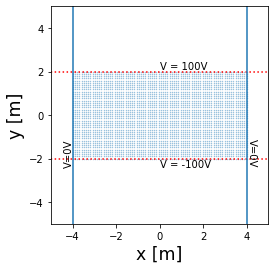

In [17]:
print('x varies across bottom edge and has shape: ', potential[:,0].shape)
print('x varies across top edge and has shape: ', potential[:,-1].shape)
print('y varies across left edge and has shape: ', potential[0,:].shape)
print('y varies across right edge and has  shape: ', potential[-1,:].shape)

# Visualization of points sampled
plt.scatter(x_positions, y_positions, s=0.2, alpha=0.5)
plt.xlim(-5,5)

# Horizontal lines
plt.axhline(-2, xmin=-5,xmax=5, c='r', ls=':')
plt.axhline(2, xmin=-5,xmax=5, c='r', ls=':')

# Vertical lines
plt.axvline(-4, ymin=-5,ymax=5)
plt.axvline(4, ymin=-5,ymax=5)

# Label what we will want to happen
plt.annotate('V = 100V', (0, 2.1))
plt.annotate('V = -100V', (0, -2.4))

plt.annotate('V=0V', (-4.4,-2.3), rotation=90)
plt.annotate('V=0V', (4.,-2.3), rotation=-90)

plt.ylim(-5,5)
plt.gca().set_aspect('equal')
plt.xlabel('x [m]', fontsize='xx-large')
plt.ylabel('y [m]', fontsize='xx-large')

**Group exercise** (5 min): Recall, you can set values in an array.  Let us create an array of zeros, `example_edge_conditioned_array` using `np.zeros`, with shape (10,1).  Let us set the first and last elements of `example_edge_conditioned_array` equal to 1. 

In [4]:
# Define example_edge_array here
### BEGIN SOLUTION
example_edge_conditioned_array = np.zeros((10,1))
example_edge_conditioned_array[0] = 1
example_edge_conditioned_array[-1] = 1
### END SOLUTION

In [5]:
"""Execute to check you're on the right track"""
assert(example_edge_conditioned_array.shape == (10,1))
### BEGIN HIDDEN TESTS
test_conditioned_array = np.zeros((10,1))
test_conditioned_array[0] = 1
test_conditioned_array[-1] = 1
assert((example_edge_conditioned_array == test_conditioned_array).all())
### END HIDDEN TESTS

**Group exercise** (5 min): Analogous to what we did for a 1-d array, `example_edge_conditioned_array`, let us do the same thing for a 2-d array, `potential`.  We wish to set boundary conditions such that:
```
x_edges = 0
y_edge_top = 100
y_edge_bottom = -100
```
See the plot we made above for the visualization of the boundary conditions.  Note, you should be able to see that the edge that is shorter has the 0 potential.  We printed out the shape of the array's edges above (we sliced the array to access elements along the edges).  **Note:** There are overlapping corners.  Set the short edges first, and the long edges second so the corners are set to -100 or 100.

There are two ways you can try to do this:

- Identify the edges through the first and/or last element indexing (e.g. 0 or -1) or
- Identify the indices corresponding the the min/max x positions or the min/max y positions (`np.argmax` and `np.abs` would be useful for this, or as an alternative np.where).

The latter approach would be agnostic to indexing order.  Use the former for the short in-class exercise.

In [6]:
# Define boundary conditions
x_edges = 0
y_edge_top = 100
y_edge_bottom = -100

# Impose boundary conditions below
### BEGIN SOLUTION
potential[0,:] = 0
potential[-1,:] = 0
potential[:,0] = -100
potential[:,-1] = 100
### END SOLUTION

In [9]:
"""Execute to check you're on the right track"""
assert((potential[0,1:-1]==0).all())
### BEGIN HIDDEN TESTS
assert((potential[-1,1:-1]==0).all())
assert((potential[:,0]==-100).all())
assert((potential[:,-1]==100).all())
### END HIDDEN TESTS

Below, we write a function that finds the edges of an array based on the position array (using `np.argmax` and `np.abs` as previously described), and sets the corresponding potential array to the specified boundary conditions. 

In [11]:
def set_boundary_conditions(potential_array, pts_in_meshgrid, 
                            bounds_left=0, bounds_right=0, 
                            bounds_top=100, bounds_bottom=-100,
                            bounds_front=None, bounds_back=None) :
    """ Returns potential array with set boundary conditions.  Sets in order of x edges, y edges, then z edges (if 3-d)

    Inputs:
    potential_array (n by m-darray) : array containing the potential at each sampled point 
    pts_in_meshgrid (n by m-darray) : x, y, and z positions for field points
    bounds_right (float) : value of potential on right edge
    bounds_left (float) : value of potential on left edge
    bounds_top (float) : value of potential on top edge
    bounds_bottom (float) : value of potential on bottom edge

    Outputs:
    potential_array (n by m-darray) : array containing the potential at each sampled point with boundary conditions set 
    """
    
    # Separate out the position arrays along each axis for readability
    x_positions = pts_in_meshgrid[0]
    y_positions = pts_in_meshgrid[1]
    if pts_in_meshgrid.shape[0] == 3 :
        z_positions = pts_in_meshgrid[2]

    # Identify the edges
    right_edge_mask = np.argmax(x_positions)
    left_edge_mask = np.argmin(x_positions)
    top_edge_mask = np.argmax(y_positions)
    bottom_edge_mask = np.argmin(y_positions)
    if pts_in_meshgrid.shape[0] == 3 :
        assert(bounds_front != None)
        assert(bounds_back != None)
        front_edge_mask = np.argmax(z_positions)
        back_edge_mask = np.argmin(z_positions)
    
    # Set the bounds
    potential_array[right_edge_mask] = bounds_right    
    potential_array[left_edge_mask] = bounds_left
    potential_array[top_edge_mask] = bounds_top
    potential_array[bottom_edge_mask] = bounds_bottom
    if pts_in_meshgrid.shape[0] == 3 :
        potential_array[front_edge_mask] = bounds_front    
        potential_array[back_edge_mask] = bounds_back
        
    return potential_array

**Open question** (5min): 
- What do the `right_edge_mask` (analogously `left_edge_mask`, etc.) represent?  What does `x_positions[right_edge_mask]` give you?
- Why do we need the `if` statements?


**Answers**:
- The indices where the x_positions are at a minimum, so `x_positions[right_edge_mask]` gives you the smallest element(s) in `x_positions`
- The `if` statements account for the possibility of working in 3d and setting up boundary conditions on the z-edges (third dimension).


In [ ]:
def relax_potential() :
    

## Effects of discretization: Example with Gauss' Law

## Gauss' law due to a spherical insulator

Gauss' law states that a closed surface has a total flux equal to the charge enclosed.  We will write a function, `calc_efield_sphere_gauss` that calculates the electric field due to an insulating sphere that we discussed in the tutorial portion, e.g. the And compare with the numerical calculation from discretized charge in the tutorial.

In [ ]:
# Let's first define our field points, points_in_meshgrid

In [ ]:
# Let's define our charge points

In [ ]:
# Let's define our functions that calculate the efield due to an array of charges

In [ ]:
def calc_efield_sphere_gauss(points_in_meshgrid, sphere_radius=1, Q=1) :
    '''
    
    '''
    
### BEGIN SOLUTION
    pass
### END SOLUTION

## Compare the Gauss' law (exact) calculation to the discretized version (2 points)

Take the function, `calc_efield_sphere_gauss`, and calculate the electric field for `points_in_meshgrid`, `efield_sphere_gauss`.    

In [ ]:
#  Calculate efield_sphere_gauss here
### BEGIN SOLUTION
efield_sphere_gauss = calc_efield_sphere_gauss(points_in_meshgrid)
### END SOLUTION

In [ ]:
"""Execute to check that you are properly calculating efield_sphere_gauss"""
#assert()
### BEGIN HIDDEN TESTS

### END HIDDEN TESTS

Now, let's plot the ratio between the two as measured along the x-axis ($y, z=0$).  First, identify the part of the arrays corresponding to the x-axis points.